In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import geodesic
from pykalman import KalmanFilter
import numpy as np
from scipy import stats

In [3]:
def charger_donnees_avec_tel(nom):
    """Charge les données des fichiers CSV avec les données du telephone."""
    try:
        gps_data = pd.read_csv(f'results/{nom}/{nom+"_gps"}.csv')
        tel_data = pd.read_csv(f'results/{nom}/{nom+"_gps_ref_1"}.csv')
        return gps_data, tel_data
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
    return None, None

In [4]:
def charger_donnees(nom):
    """Charge les données des fichiers CSV."""
    try:
        gps_data = pd.read_csv(f'results/{nom}/{nom}_gnss.csv')
        imu_data = pd.read_csv(f'results/{nom}/{nom}_imu.csv')
        return gps_data, imu_data
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
    return None, None

In [5]:
convert_time = lambda x: datetime.strptime(x, "%Y/%m/%d - %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%SZ")

In [6]:
def fusionner_donnees(gps_data, tel_data):
    """Fusionne les données GPS et téléphone sur la colonne UTC."""
    return pd.merge_asof(
        gps_data.sort_values('UTC'),
        tel_data.sort_values('UTC'),
        on='UTC', suffixes=('_GPS', '_Tel')
    ).dropna()

In [7]:

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance haversine entre deux points GPS."""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

In [8]:
def calculer_erreurs(merged_df):
    """Ajoute une colonne de distance et affiche les statistiques d'erreur."""
    merged_df['distance'] = merged_df.apply(lambda row: haversine_distance(
        row['Latitude_GPS'], row['Longitude_GPS'], row['Latitude_Tel'], row['Longitude_Tel']), axis=1)
    print(f"Erreur moyenne : {merged_df['distance'].mean():.2f} mètres")
    print(f"Erreur max : {merged_df['distance'].max():.2f} mètres")
    print(f"Erreur min : {merged_df['distance'].min():.2f} mètres")
    return merged_df


In [9]:
def creer_dossier_sauvegarde(nomresult):
    """Crée un dossier de sauvegarde pour les résultats."""
    output_folder = f'traitements/{nomresult}'
    os.makedirs(output_folder, exist_ok=True)
    return output_folder

In [10]:
def calculer_chemin_moyen(merged_df):
    merged_df['Latitude_corrigée'] = merged_df[['Latitude_GPS', 'Latitude_Tel']].mean(axis=1)
    merged_df['Longitude_corrigée'] = merged_df[['Longitude_GPS', 'Longitude_Tel']].mean(axis=1)

In [11]:
def generer_graphiques(merged_df, output_folder):
    """Génère et sauvegarde différents graphiques de comparaison."""
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Longitude_GPS'], merged_df['Latitude_GPS'], label='GPS', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_Tel'], merged_df['Latitude_Tel'], label='Tel', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_corrigée'], merged_df['Latitude_corrigée'], label='Moyen', alpha=0.6, marker='x')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Comparaison des trajets GPS')
    plt.savefig(f'{output_folder}/comparaison_trajets.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['distance'], label='Distance GPS - Tel')
    plt.xlabel('Index')
    plt.ylabel('Distance (mètres)')
    plt.title("Évolution de l'erreur")
    plt.legend()
    plt.savefig(f'{output_folder}/erreur_evolution.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Latitude_GPS'], label='Latitude GPS')
    plt.plot(merged_df['Latitude_Tel'], label='Latitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_latitude.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Longitude_GPS'], label='Longitude GPS')
    plt.plot(merged_df['Longitude_Tel'], label='Longitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_longitude.png')
    plt.show()

In [12]:
def sauvegarder_resultats(merged_df, output_folder):
    output_file = f'{output_folder}/results.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"Résultats sauvegardés dans : {output_file}")

In [13]:
def calculer_vitesse_acceleration(df, lat_col='Latitude_GPS', lon_col='Longitude_GPS', time_col='UTC'):
    df = df.copy().sort_values(time_col)

    df['time_diff'] = df[time_col].diff().dt.total_seconds()
    df['lat_diff'] = df[lat_col].diff()
    df['lon_diff'] = df[lon_col].diff()

    df['distance_diff'] = df.apply(
        lambda row: haversine_distance(
            row[lat_col], row[lon_col],
            row[lat_col] - row['lat_diff'],
            row[lon_col] - row['lon_diff']
        ) if not np.isnan(row['lat_diff']) else np.nan,
        axis=1
    )

    df['vitesse'] = df['distance_diff'] / df['time_diff']

    df['acceleration'] = df['vitesse'].diff() / df['time_diff']

    return df

In [14]:
def generer_boxplots(df, output_folder):
    """Génère des boxplots pour la vitesse et l'accélération avec les limites des moustaches."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bp = plt.boxplot(df['vitesse'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
    plt.title('Distribution de la vitesse')
    plt.ylabel('Vitesse (m/s)')

    plt.subplot(1, 2, 2)
    bp = plt.boxplot(df['acceleration'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)

    plt.title('Distribution de l\'accélération')
    plt.ylabel('Accélération (m/s²)')
    plt.tight_layout()
    plt.savefig(f'{output_folder}/boxplots_vitesse_acceleration.png')
    plt.show()

In [15]:
def identifier_valeurs_aberrantes_boxplot(df, k=1.5):
    """
    Identifie les valeurs aberrantes en utilisant les limites des boxplots (méthode IQR).
    k: facteur pour ajuster la longueur des moustaches (typiquement 1.5)
    """
    df = df.copy()

    Q1_v = df['vitesse'].quantile(0.25)
    Q3_v = df['vitesse'].quantile(0.75)
    IQR_v = Q3_v - Q1_v
    limite_basse_v = Q1_v - k * IQR_v
    limite_haute_v = Q3_v + k * IQR_v

    Q1_a = df['acceleration'].quantile(0.25)
    Q3_a = df['acceleration'].quantile(0.75)
    IQR_a = Q3_a - Q1_a
    limite_basse_a = Q1_a - k * IQR_a
    limite_haute_a = Q3_a + k * IQR_a

    df['aberrant_vitesse'] = (df['vitesse'] < limite_basse_v) | (df['vitesse'] > limite_haute_v)
    df['aberrant_acceleration'] = (df['acceleration'] < limite_basse_a) | (df['acceleration'] > limite_haute_a)
    df['aberrant'] = df['aberrant_vitesse'] | df['aberrant_acceleration']

    df['limite_basse_vitesse'] = limite_basse_v
    df['limite_haute_vitesse'] = limite_haute_v
    df['limite_basse_acceleration'] = limite_basse_a
    df['limite_haute_acceleration'] = limite_haute_a

    return df

In [16]:
def generer_graphiques_aberrants(df, output_folder):
    """Génère des graphiques montrant les valeurs aberrantes."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(df['vitesse'], label='Vitesse normale', color='blue')
    plt.scatter(df[df['aberrant_vitesse']].index,
                df[df['aberrant_vitesse']]['vitesse'],
                color='red', label='Valeurs aberrantes')
    plt.title('Vitesse avec valeurs aberrantes')
    plt.ylabel('Vitesse (m/s)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df['acceleration'], label='Accélération normale', color='green')
    plt.scatter(df[df['aberrant_acceleration']].index,
                df[df['aberrant_acceleration']]['acceleration'],
                color='red', label='Valeurs aberrantes')
    plt.title('Accélération avec valeurs aberrantes')
    plt.ylabel('Accélération (m/s²)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{output_folder}/valeurs_aberrantes.png')
    plt.show()

In [17]:
def traitement(nom):
    """Orchestre le traitement complet des fichiers."""
    gps_data, tel_data = charger_donnees_avec_tel(nom)
    if gps_data is None or tel_data is None:
        return

    gps_data['UTC'] = pd.to_datetime(gps_data['UTC'], errors='coerce')
    tel_data['UTC'] = pd.to_datetime(tel_data['UTC'], errors='coerce')

    merged_df = fusionner_donnees(gps_data, tel_data)
    merged_df = calculer_erreurs(merged_df)

    calculer_chemin_moyen(merged_df)

    merged_df = calculer_vitesse_acceleration(merged_df)

    merged_df = identifier_valeurs_aberrantes_boxplot(merged_df)

    output_folder = creer_dossier_sauvegarde(nom)

    generer_graphiques(merged_df, output_folder)

    generer_boxplots(merged_df, output_folder)
    generer_graphiques_aberrants(merged_df, output_folder)

    sauvegarder_resultats(merged_df, output_folder)

Erreur moyenne : 69.68 mètres
Erreur max : 91.80 mètres
Erreur min : 48.42 mètres


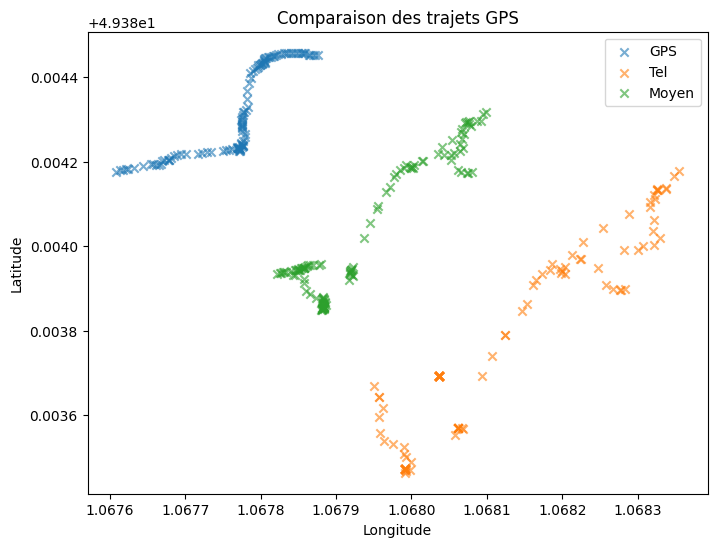

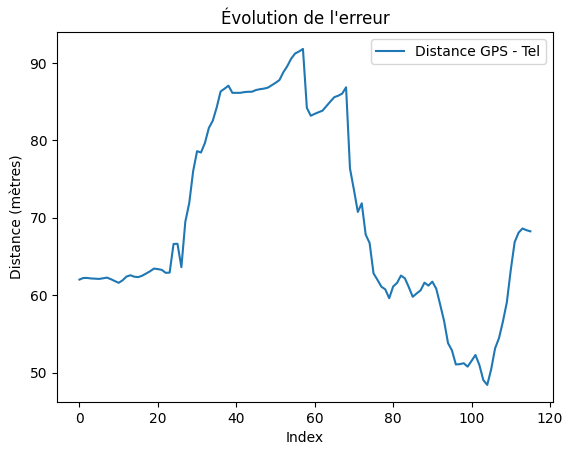

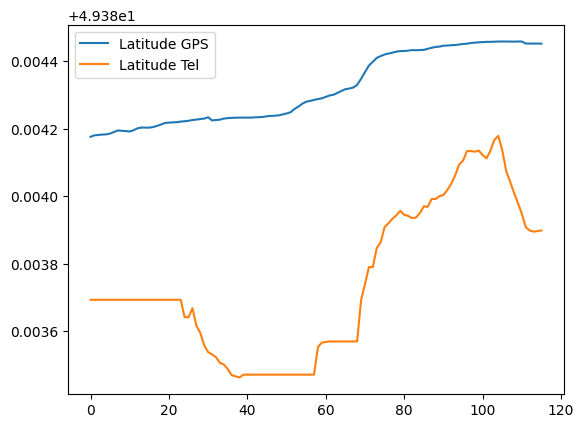

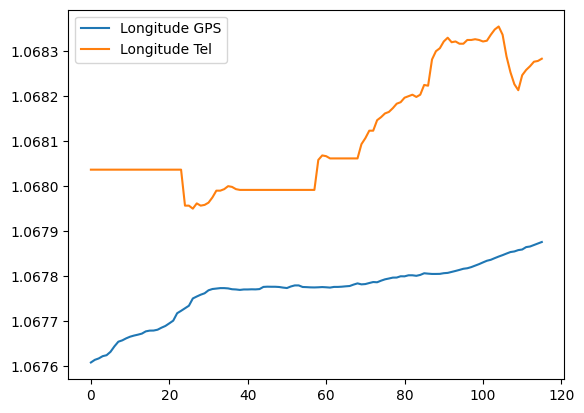

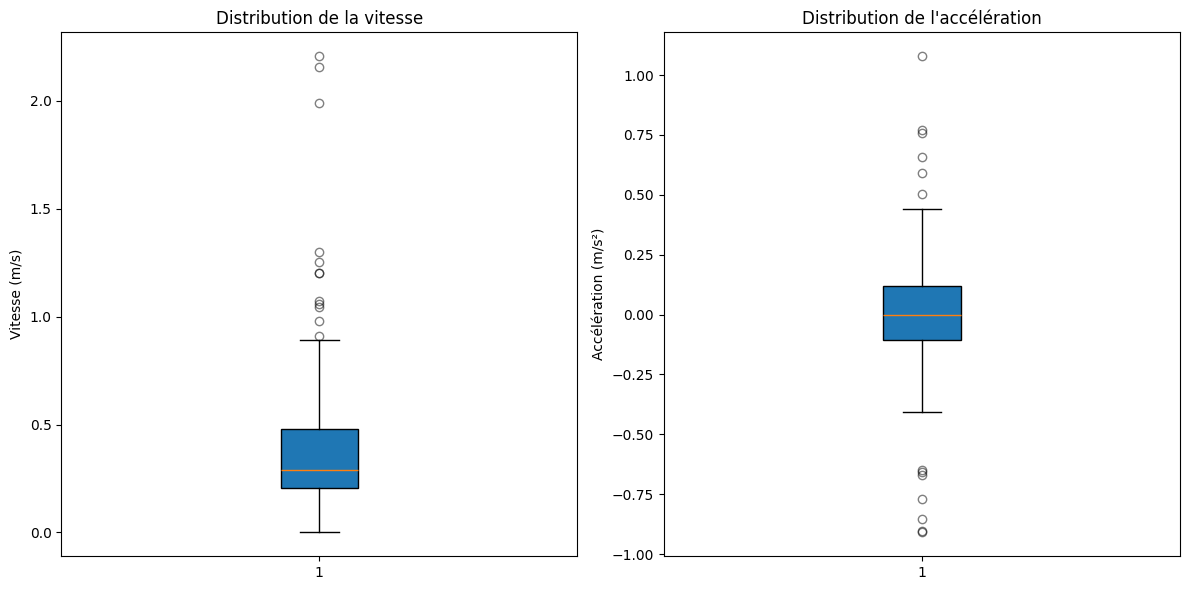

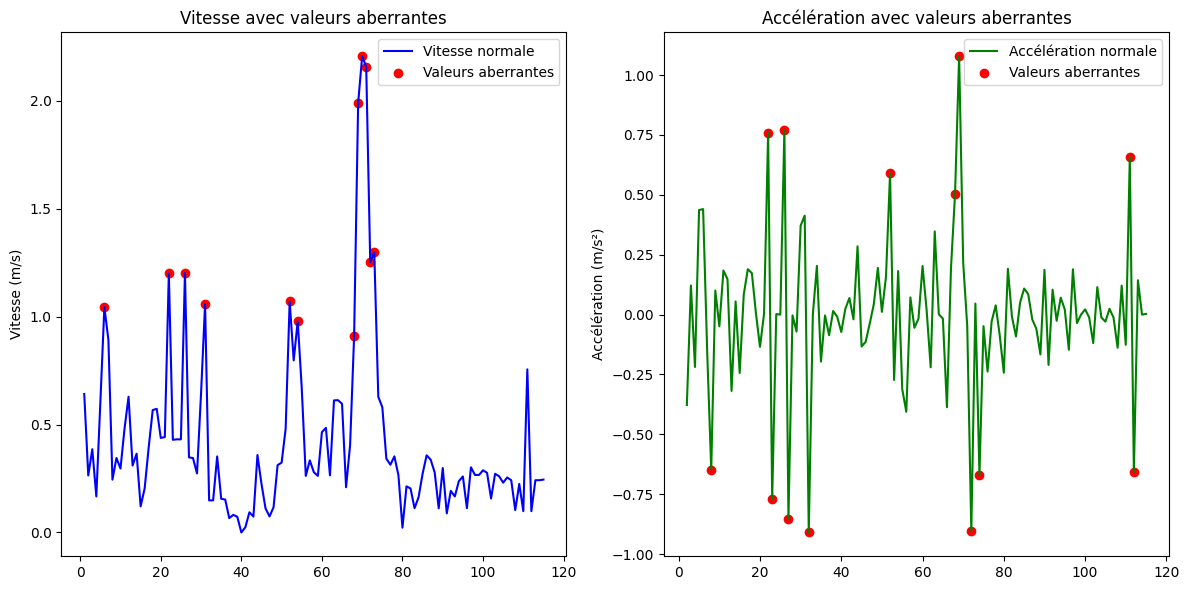

Résultats sauvegardés dans : traitements/immobile_interieur_1/results.csv
Erreur moyenne : 59.75 mètres
Erreur max : 104.34 mètres
Erreur min : 4.76 mètres


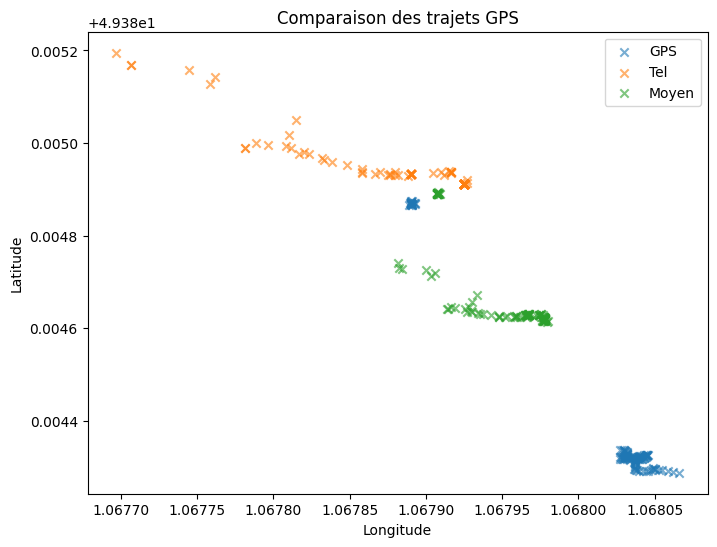

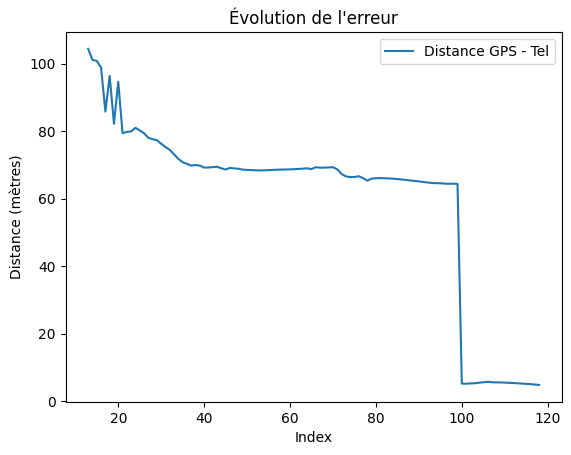

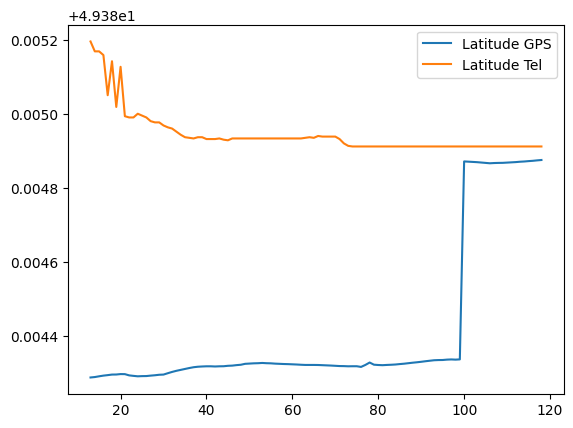

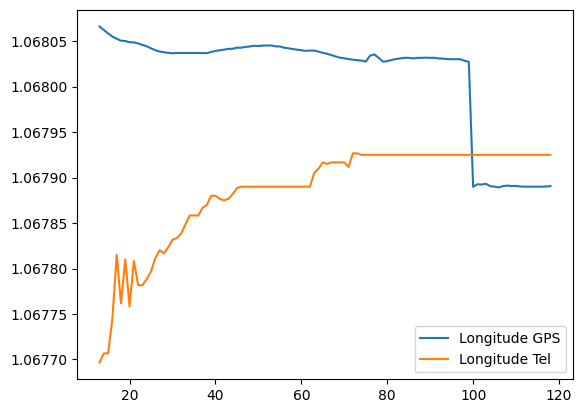

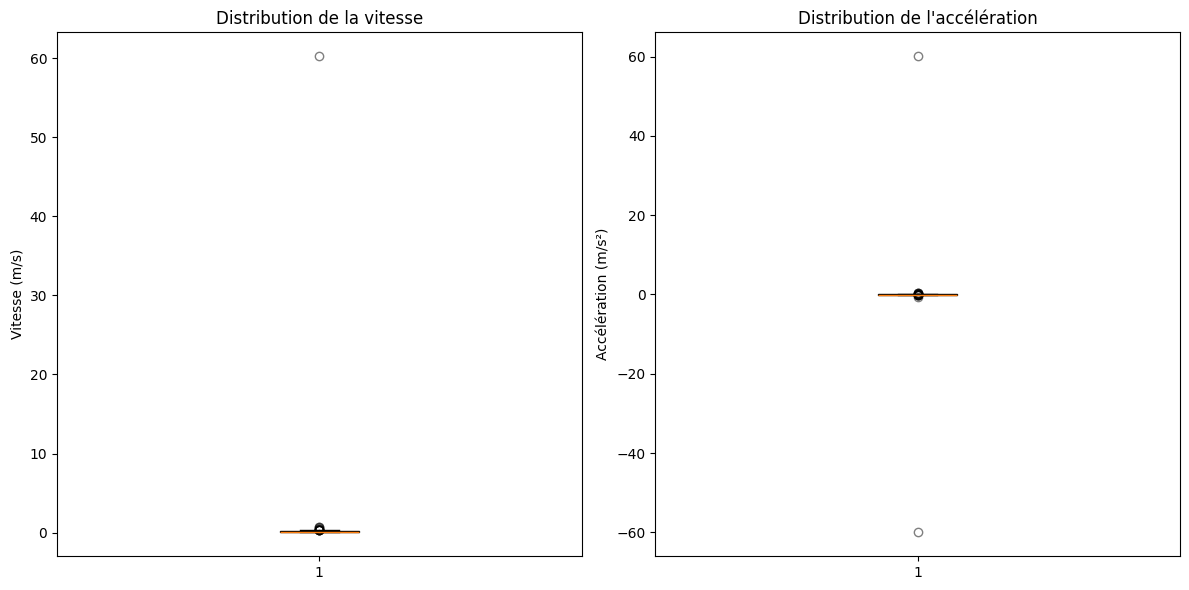

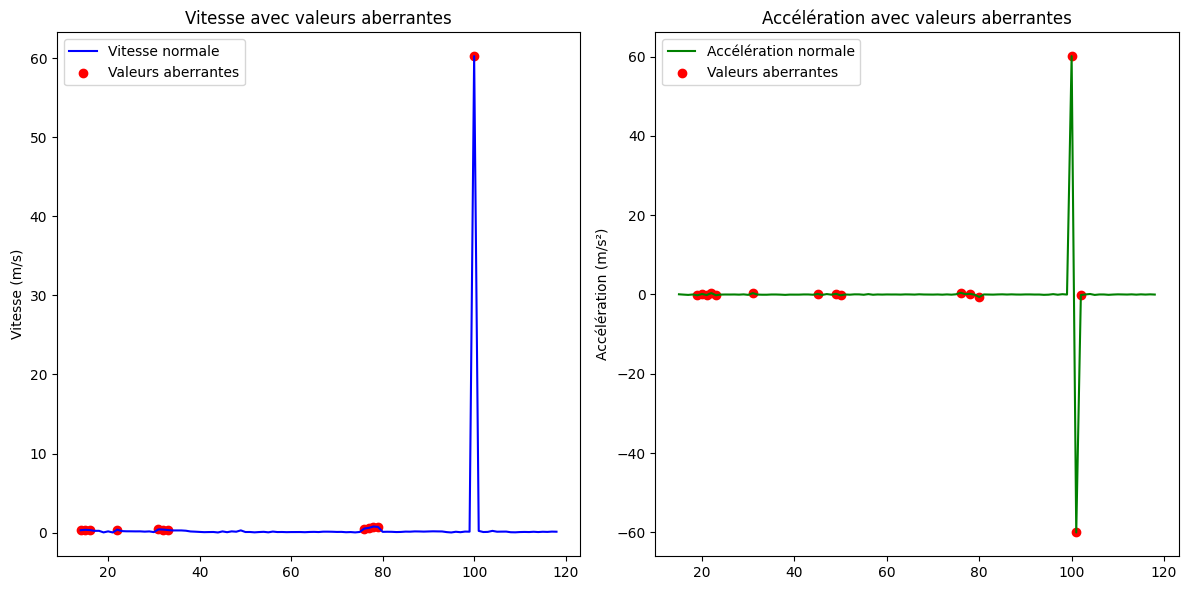

Résultats sauvegardés dans : traitements/immobile_exterieur_1/results.csv
Erreur moyenne : 67.91 mètres
Erreur max : 309.06 mètres
Erreur min : 3.75 mètres


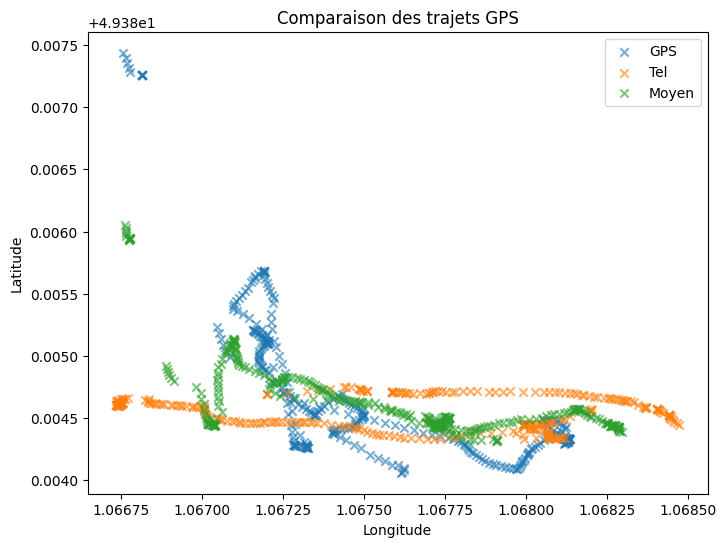

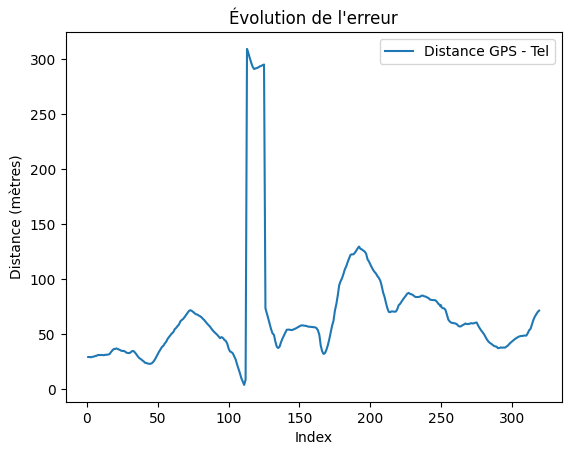

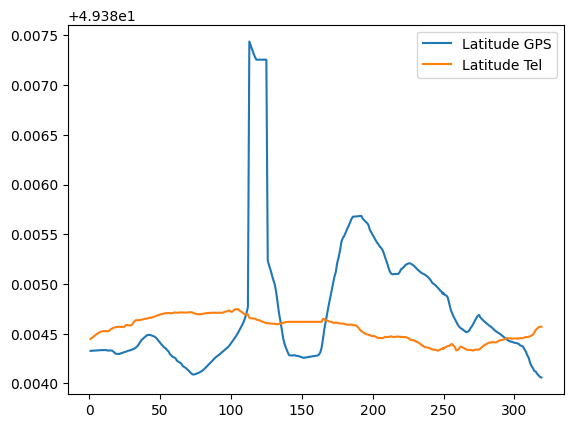

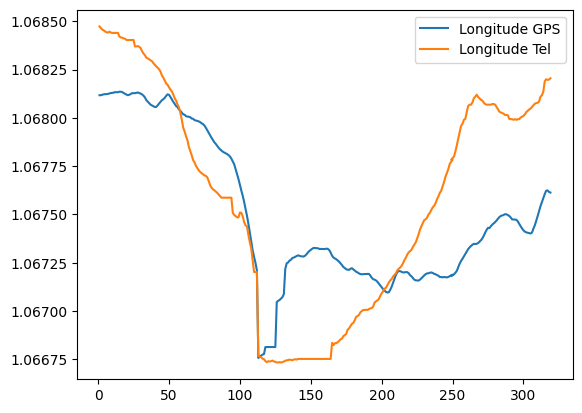

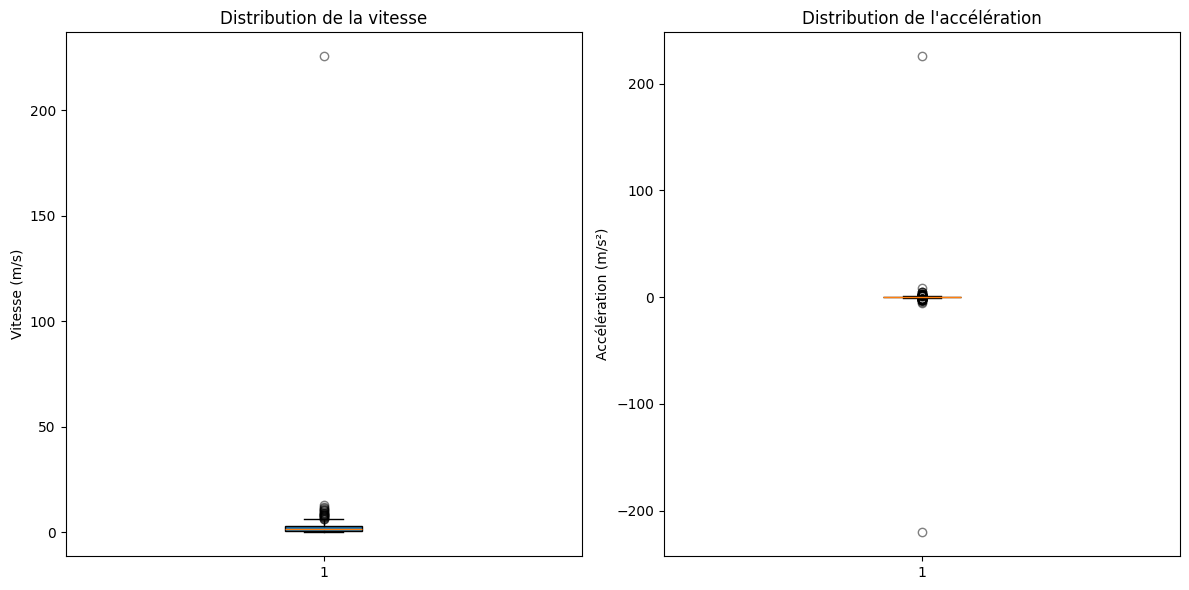

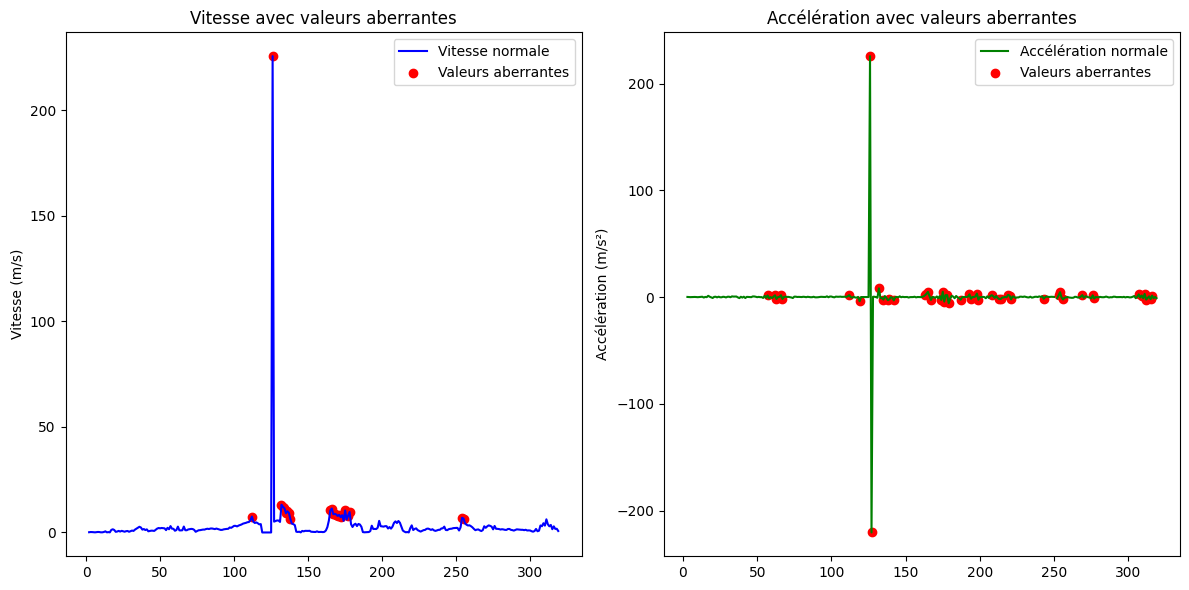

Résultats sauvegardés dans : traitements/mouvement_interieur_1/results.csv
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/mouvement_interieur_exterieur_1/mouvement_interieur_exterieur_1_gps_ref_1.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/mouvement_interieur_exterieur_2/mouvement_interieur_exterieur_2_gps_ref_1.csv'
Erreur moyenne : 8.09 mètres
Erreur max : 20.28 mètres
Erreur min : 0.66 mètres


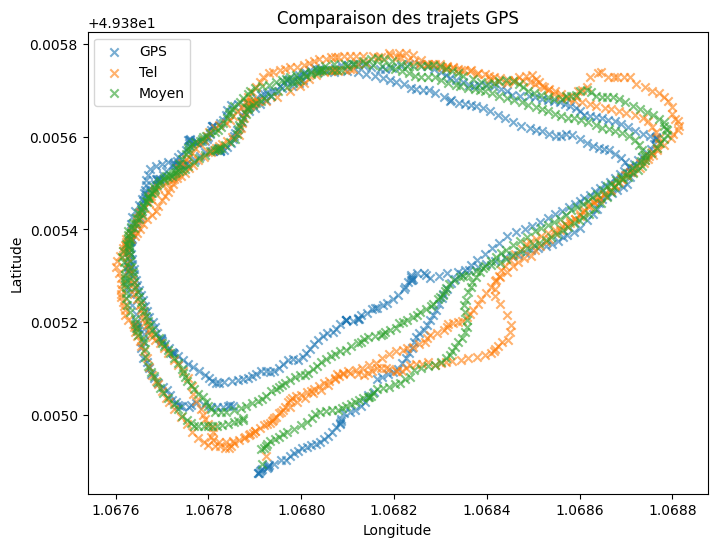

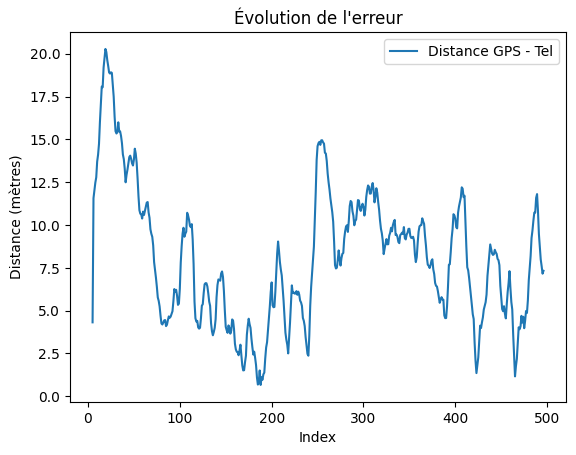

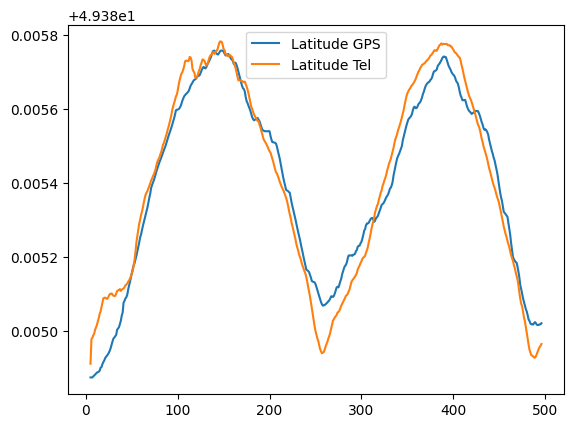

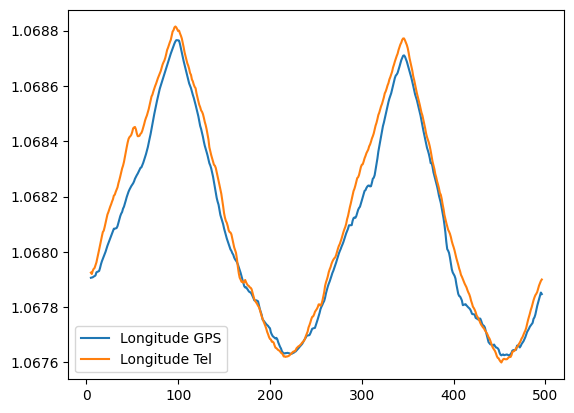

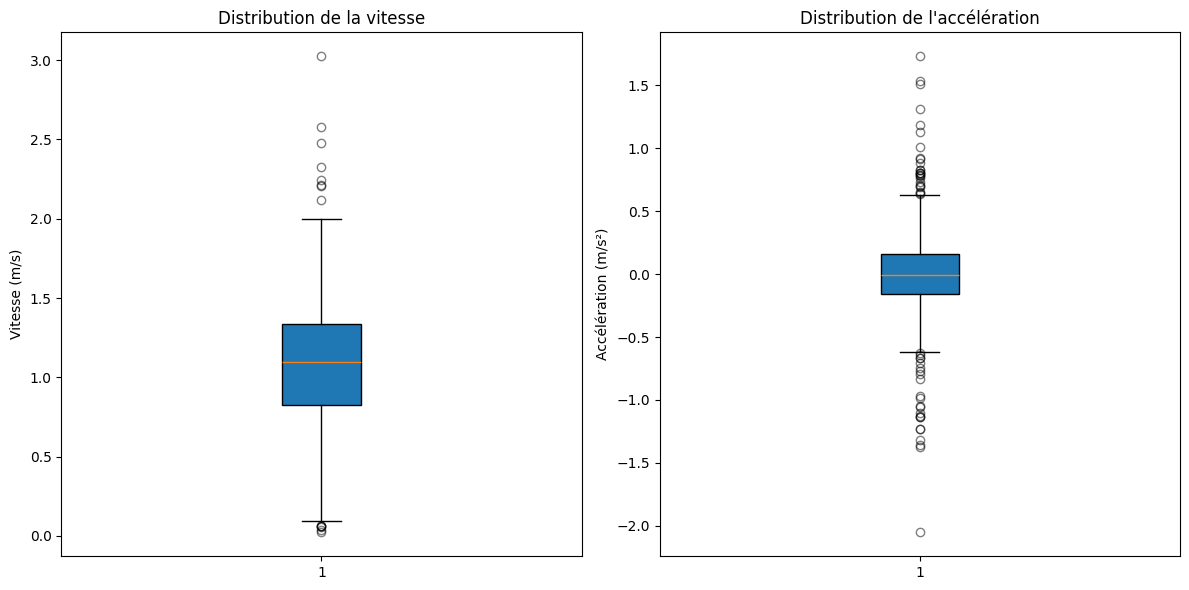

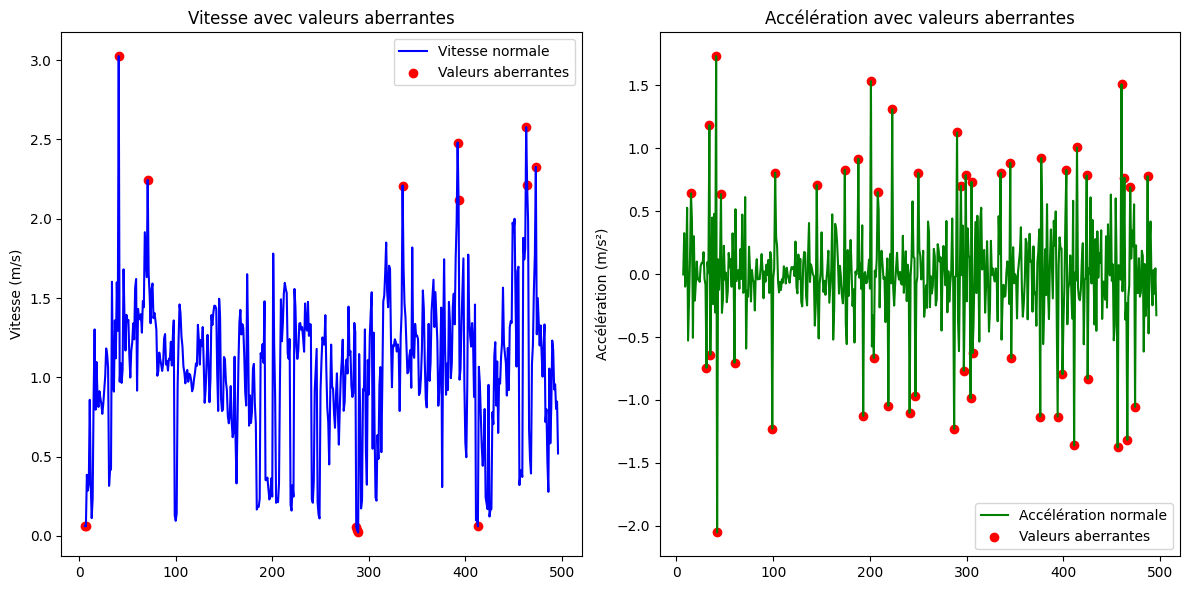

Résultats sauvegardés dans : traitements/mouvement_exterieur_21/results.csv


In [18]:
traite = ["immobile_interieur_1",
          "immobile_exterieur_1",
          "mouvement_interieur_1",
          "mouvement_interieur_exterieur_1",
          "mouvement_interieur_exterieur_2",
          "mouvement_exterieur_21"
          ]

for ind, itineraire in enumerate(traite):
    traitement(traite[ind])

In [19]:
gps_data, imu_data = charger_donnees('mouvement_exterieur_3')

In [20]:
gps_data

,Timestamp,UTC,Latitude,Longitude
0,1.745335e+09,2025/04/22 - 15:11:30,49.384977,1.067789
1,1.745335e+09,2025/04/22 - 15:11:31,49.384977,1.067789
2,1.745335e+09,2025/04/22 - 15:11:32,49.384977,1.067789
3,1.745335e+09,2025/04/22 - 15:11:33,49.384977,1.067790
4,1.745335e+09,2025/04/22 - 15:11:34,49.384985,1.067792
...,...,...,...,...
196,1.745335e+09,2025/04/22 - 15:14:46,49.384966,1.067584
197,1.745335e+09,2025/04/22 - 15:14:47,49.384960,1.067596
198,1.745335e+09,2025/04/22 - 15:14:48,49.384954,1.067611
199,1.745335e+09,2025/04/22 - 15:14:49,49.384950,1.067625


In [21]:
imu_data

,Timestamp,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z
0,1.745335e+09,0.997777,0.063745,0.105469,-0.08750,-0.07000,-1.85500,-0.246711,0.120433,-0.167787
1,1.745335e+09,1.001010,0.063745,0.102053,-0.07000,-0.76125,0.34125,-0.251096,0.127740,-0.173487
2,1.745335e+09,1.003450,0.047153,0.101260,-0.12250,0.09625,0.77875,-0.251096,0.127740,-0.173487
3,1.745335e+09,1.003084,0.064782,0.101931,-0.21875,-0.21000,0.41125,-0.251096,0.127740,-0.173487
4,1.745335e+09,1.004670,0.063379,0.105103,-0.19250,0.08750,0.40250,-0.251096,0.127740,-0.173487
...,...,...,...,...,...,...,...,...,...,...
732,1.745335e+09,0.518500,0.502945,0.228567,-18.83000,-14.88375,-23.95750,-0.270973,-0.090324,-0.314674
733,1.745335e+09,1.269166,0.654225,0.076067,-21.97125,-30.71250,-18.21750,-0.270973,-0.090324,-0.314674
734,1.745335e+09,1.498099,0.396439,0.035319,-23.12625,-27.04625,-29.65375,-0.270973,-0.090324,-0.314674
735,1.745335e+09,1.318271,0.352214,0.166042,-25.20000,-24.61375,-26.72250,-0.270973,-0.090324,-0.314674


In [22]:
datas = pd.merge_asof(
        gps_data.sort_values('Timestamp'),
        imu_data.sort_values('Timestamp'),
        on='Timestamp', suffixes=('_GPS', '_IMU')
).dropna()

In [23]:
datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z
0,1.745335e+09,2025/04/22 - 15:11:30,49.384977,1.067789,1.001437,0.062342,0.103700,-0.08750,-0.02625,0.51625,-0.241158,0.123940,-0.174072
1,1.745335e+09,2025/04/22 - 15:11:31,49.384977,1.067789,1.004060,0.076067,0.099064,-0.11375,-0.10500,0.45500,-0.231804,0.125402,-0.173487
2,1.745335e+09,2025/04/22 - 15:11:32,49.384977,1.067789,0.981124,0.062647,0.077531,-0.08750,0.53375,0.42875,-0.239111,0.121017,-0.176410
3,1.745335e+09,2025/04/22 - 15:11:33,49.384977,1.067790,0.788791,0.064782,0.046238,-60.20000,-23.52875,-19.91500,-0.284127,-0.104648,-0.206811
4,1.745335e+09,2025/04/22 - 15:11:34,49.384985,1.067792,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1.745335e+09,2025/04/22 - 15:14:46,49.384966,1.067584,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674
197,1.745335e+09,2025/04/22 - 15:14:47,49.384960,1.067596,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674
198,1.745335e+09,2025/04/22 - 15:14:48,49.384954,1.067611,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674
199,1.745335e+09,2025/04/22 - 15:14:49,49.384950,1.067625,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674


In [24]:
# Exemple de données pour w0
w0 = np.array([datas["Magneto X"][0], datas["Magneto Y"][0], datas["Magneto Z"][0]])

# Norme du vecteur du champ magnétique
norme_w0 = np.linalg.norm(w0)

theta_x = np.arccos(w0[0] / norme_w0)
theta_y = np.arccos(w0[1] / norme_w0)
theta_z = np.arccos(w0[2] / norme_w0)

theta_x_deg = np.degrees(theta_x)
theta_y_deg = np.degrees(theta_y)
theta_z_deg = np.degrees(theta_z)

print(f"L'angle par rapport à l'axe x est de {theta_x_deg:.2f}°")
print(f"L'angle par rapport à l'axe y est de {theta_y_deg:.2f}°")
print(f"L'angle par rapport à l'axe z est de {theta_z_deg:.2f}°")

w0 = np.array([theta_x, theta_y, theta_z])

L'angle par rapport à l'axe x est de 138.46°
L'angle par rapport à l'axe y est de 67.38°
L'angle par rapport à l'axe z est de 122.70°


In [25]:
Rt = 6371000
datas["x"] = Rt * np.cos(np.radians(datas["Latitude"])) * np.cos(np.radians(datas["Longitude"]))
datas["y"] = Rt * np.cos(np.radians(datas["Latitude"])) * np.sin(np.radians(datas["Longitude"]))
datas["z"] = Rt * np.sin(np.radians(datas["Latitude"]))

datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z,x,y,z
0,1.745335e+09,2025/04/22 - 15:11:30,49.384977,1.067789,1.001437,0.062342,0.103700,-0.08750,-0.02625,0.51625,-0.241158,0.123940,-0.174072,4.146631e+06,77287.352882,4.836230e+06
1,1.745335e+09,2025/04/22 - 15:11:31,49.384977,1.067789,1.004060,0.076067,0.099064,-0.11375,-0.10500,0.45500,-0.231804,0.125402,-0.173487,4.146631e+06,77287.365206,4.836230e+06
2,1.745335e+09,2025/04/22 - 15:11:32,49.384977,1.067789,0.981124,0.062647,0.077531,-0.08750,0.53375,0.42875,-0.239111,0.121017,-0.176410,4.146631e+06,77287.365731,4.836230e+06
3,1.745335e+09,2025/04/22 - 15:11:33,49.384977,1.067790,0.788791,0.064782,0.046238,-60.20000,-23.52875,-19.91500,-0.284127,-0.104648,-0.206811,4.146631e+06,77287.402179,4.836230e+06
4,1.745335e+09,2025/04/22 - 15:11:34,49.384985,1.067792,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146630e+06,77287.558464,4.836231e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1.745335e+09,2025/04/22 - 15:14:46,49.384966,1.067584,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146632e+06,77272.498186,4.836229e+06
197,1.745335e+09,2025/04/22 - 15:14:47,49.384960,1.067596,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146632e+06,77273.411491,4.836229e+06
198,1.745335e+09,2025/04/22 - 15:14:48,49.384954,1.067611,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146633e+06,77274.494451,4.836229e+06
199,1.745335e+09,2025/04/22 - 15:14:49,49.384950,1.067625,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146633e+06,77275.526279,4.836228e+06


In [26]:
gyro = datas[["Gyro X", "Gyro Y", "Gyro Z"]].to_numpy()
wk = np.zeros_like(gyro)
wk[0] = w0 + gyro[0]
for k in range(1, len(gyro)):
    wk[k] = wk[k-1] + gyro[k]
datas["w_x"] = wk[:, 0]
datas["w_y"] = wk[:, 1]
datas["w_z"] = wk[:, 2]
datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z,x,y,z,w_x,w_y,w_z
0,1.745335e+09,2025/04/22 - 15:11:30,49.384977,1.067789,1.001437,0.062342,0.103700,-0.08750,-0.02625,0.51625,-0.241158,0.123940,-0.174072,4.146631e+06,77287.352882,4.836230e+06,2.329016,1.14971,2.657773
1,1.745335e+09,2025/04/22 - 15:11:31,49.384977,1.067789,1.004060,0.076067,0.099064,-0.11375,-0.10500,0.45500,-0.231804,0.125402,-0.173487,4.146631e+06,77287.365206,4.836230e+06,2.215266,1.04471,3.112773
2,1.745335e+09,2025/04/22 - 15:11:32,49.384977,1.067789,0.981124,0.062647,0.077531,-0.08750,0.53375,0.42875,-0.239111,0.121017,-0.176410,4.146631e+06,77287.365731,4.836230e+06,2.127766,1.57846,3.541523
3,1.745335e+09,2025/04/22 - 15:11:33,49.384977,1.067790,0.788791,0.064782,0.046238,-60.20000,-23.52875,-19.91500,-0.284127,-0.104648,-0.206811,4.146631e+06,77287.402179,4.836230e+06,-58.072234,-21.95029,-16.373477
4,1.745335e+09,2025/04/22 - 15:11:34,49.384985,1.067792,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146630e+06,77287.558464,4.836231e+06,-84.120984,-53.22279,-41.074727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1.745335e+09,2025/04/22 - 15:14:46,49.384966,1.067584,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146632e+06,77272.498186,4.836229e+06,-5085.480984,-6057.54279,-4783.714727
197,1.745335e+09,2025/04/22 - 15:14:47,49.384960,1.067596,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146632e+06,77273.411491,4.836229e+06,-5111.529734,-6088.81529,-4808.415977
198,1.745335e+09,2025/04/22 - 15:14:48,49.384954,1.067611,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146633e+06,77274.494451,4.836229e+06,-5137.578484,-6120.08779,-4833.117227
199,1.745335e+09,2025/04/22 - 15:14:49,49.384950,1.067625,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,-0.270973,-0.090324,-0.314674,4.146633e+06,77275.526279,4.836228e+06,-5163.627234,-6151.36029,-4857.818477


In [27]:
from scipy.spatial.transform import Rotation as R

accel = datas[["Accel X", "Accel Y", "Accel Z"]].to_numpy()

accel_corr = np.zeros_like(accel)

for k in range(len(accel)):
    w = wk[k]
    angle = np.linalg.norm(w)
    if angle != 0:
        axis = -w / angle
        rot = R.from_rotvec(axis * angle)
        accel_corr[k] = rot.apply(accel[k])
    else:
        accel_corr[k] = accel[k]

datas["Accel_corr_X"] = accel_corr[:, 0]
datas["Accel_corr_Y"] = accel_corr[:, 1]
datas["Accel_corr_Z"] = accel_corr[:, 2]

datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,...,Magneto Z,x,y,z,w_x,w_y,w_z,Accel_corr_X,Accel_corr_Y,Accel_corr_Z
0,1.745335e+09,2025/04/22 - 15:11:30,49.384977,1.067789,1.001437,0.062342,0.103700,-0.08750,-0.02625,0.51625,...,-0.174072,4.146631e+06,77287.352882,4.836230e+06,2.329016,1.14971,2.657773,-0.016156,0.711950,0.714411
1,1.745335e+09,2025/04/22 - 15:11:31,49.384977,1.067789,1.004060,0.076067,0.099064,-0.11375,-0.10500,0.45500,...,-0.173487,4.146631e+06,77287.365206,4.836230e+06,2.215266,1.04471,3.112773,-0.089455,0.776815,0.642100
2,1.745335e+09,2025/04/22 - 15:11:32,49.384977,1.067789,0.981124,0.062647,0.077531,-0.08750,0.53375,0.42875,...,-0.176410,4.146631e+06,77287.365731,4.836230e+06,2.127766,1.57846,3.541523,0.042431,0.954578,0.243969
3,1.745335e+09,2025/04/22 - 15:11:33,49.384977,1.067790,0.788791,0.064782,0.046238,-60.20000,-23.52875,-19.91500,...,-0.206811,4.146631e+06,77287.402179,4.836230e+06,-58.072234,-21.95029,-16.373477,0.697438,0.374308,-0.044710
4,1.745335e+09,2025/04/22 - 15:11:34,49.384985,1.067792,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,...,-0.314674,4.146630e+06,77287.558464,4.836231e+06,-84.120984,-53.22279,-41.074727,1.200197,0.856497,0.001709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1.745335e+09,2025/04/22 - 15:14:46,49.384966,1.067584,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,...,-0.314674,4.146632e+06,77272.498186,4.836229e+06,-5085.480984,-6057.54279,-4783.714727,1.057911,1.003534,-0.218643
197,1.745335e+09,2025/04/22 - 15:14:47,49.384960,1.067596,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,...,-0.314674,4.146632e+06,77273.411491,4.836229e+06,-5111.529734,-6088.81529,-4808.415977,0.541285,0.192135,1.357998
198,1.745335e+09,2025/04/22 - 15:14:48,49.384954,1.067611,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,...,-0.314674,4.146633e+06,77274.494451,4.836229e+06,-5137.578484,-6120.08779,-4833.117227,0.320443,1.439164,0.013623
199,1.745335e+09,2025/04/22 - 15:14:49,49.384950,1.067625,1.400865,0.441884,0.127978,-26.04875,-31.27250,-24.70125,...,-0.314674,4.146633e+06,77275.526279,4.836228e+06,-5163.627234,-6151.36029,-4857.818477,1.227719,0.044399,0.815351


In [28]:
# On suppose que tu as un DataFrame `datas` avec les colonnes suivantes :
# "Accel_corr_X", "Accel_corr_Y", "Accel_corr_Z", "x", "y", "z"

dt = 1.0  # intervalle de temps en secondes

# Matrice de transition (état = [x, y, z, vx, vy, vz])
F = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
])

# Matrice de commande B (accélération intégrée)
B = np.array([
    [0.5 * dt**2, 0, 0],
    [0, 0.5 * dt**2, 0],
    [0, 0, 0.5 * dt**2],
    [dt, 0, 0],
    [0, dt, 0],
    [0, 0, dt],
])

# Observation partielle : on observe uniquement les positions (x, y, z)
H = np.zeros((3, 6))
H[0, 0] = 1
H[1, 1] = 1
H[2, 2] = 1

# Extraction des commandes (accélérations corrigées)
U = datas[["Accel_corr_X", "Accel_corr_Y", "Accel_corr_Z"]].values

# Extraction des observations (positions mesurées)
observations = datas[["x", "y", "z"]].values

# Initialisation de l'état [x, y, z, vx, vy, vz]
initial_state = np.zeros(6)
initial_covariance = np.eye(6) * 0.1

# Initialisation du filtre
kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_covariance=np.eye(6) * 0.01,
    observation_covariance=np.eye(3) * 1,
    initial_state_mean=initial_state,
    initial_state_covariance=initial_covariance,
)

# Boucle de filtrage manuelle
filtered_states = []
state_mean = initial_state
state_cov = initial_covariance

for t in range(len(U)):
    u = U[t]
    control_effect = B @ u

    # Prédiction
    state_mean = F @ state_mean + control_effect
    state_cov = F @ state_cov @ F.T + kf.transition_covariance

    # Mise à jour avec observation de position
    observation = observations[t]
    state_mean, state_cov = kf.filter_update(
        filtered_state_mean=state_mean,
        filtered_state_covariance=state_cov,
        observation=observation
    )

    filtered_states.append(state_mean)

# Résultat final : tableau numpy (N, 6) avec positions et vitesses
filtered_states = np.array(filtered_states)

# Tu peux l’ajouter au DataFrame si tu veux
datas["x_kf"] = filtered_states[:, 0]
datas["y_kf"] = filtered_states[:, 1]
datas["z_kf"] = filtered_states[:, 2]
datas["vx_kf"] = filtered_states[:, 3]
datas["vy_kf"] = filtered_states[:, 4]
datas["vz_kf"] = filtered_states[:, 5]


Erreur moyenne en x : -1307.631 m
Erreur moyenne en y : -27.827 m
Erreur moyenne en z : -1524.352 m
Écart-type de l'erreur en x : 224618.868 m
Écart-type de l'erreur en y : 4186.711 m
Écart-type de l'erreur en z : 261973.613 m
Corrélation entre x et x_kf : 0.004
Corrélation entre y et y_kf : 0.006
Corrélation entre z et z_kf : -0.004


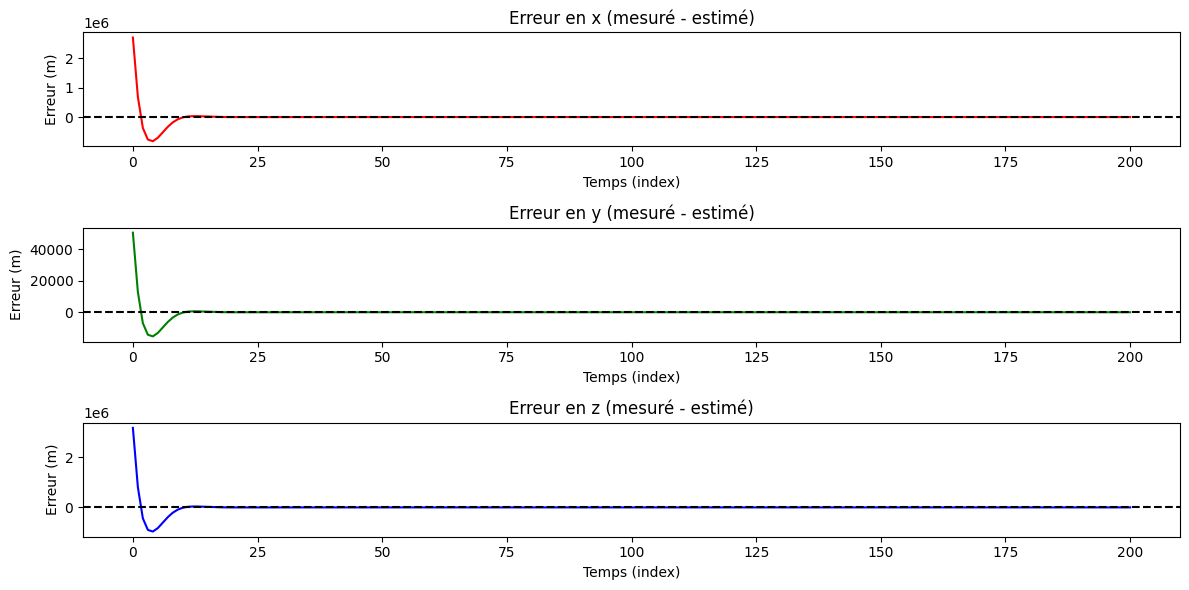

In [29]:
# Calcul des erreurs entre mesures et estimations (filtrées)
datas['error_x'] = datas['x'] - datas['x_kf']
datas['error_y'] = datas['y'] - datas['y_kf']
datas['error_z'] = datas['z'] - datas['z_kf']

# Calcul des statistiques pour l'erreur
error_x_mean = np.mean(datas['error_x'])
error_y_mean = np.mean(datas['error_y'])
error_z_mean = np.mean(datas['error_z'])

error_x_std = np.std(datas['error_x'])
error_y_std = np.std(datas['error_y'])
error_z_std = np.std(datas['error_z'])

# Affichage des résultats statistiques
print(f"Erreur moyenne en x : {error_x_mean:.3f} m")
print(f"Erreur moyenne en y : {error_y_mean:.3f} m")
print(f"Erreur moyenne en z : {error_z_mean:.3f} m")

print(f"Écart-type de l'erreur en x : {error_x_std:.3f} m")
print(f"Écart-type de l'erreur en y : {error_y_std:.3f} m")
print(f"Écart-type de l'erreur en z : {error_z_std:.3f} m")

# Calcul de la corrélation entre les valeurs mesurées et estimées
corr_x = np.corrcoef(datas['x'], datas['x_kf'])[0, 1]
corr_y = np.corrcoef(datas['y'], datas['y_kf'])[0, 1]
corr_z = np.corrcoef(datas['z'], datas['z_kf'])[0, 1]

print(f"Corrélation entre x et x_kf : {corr_x:.3f}")
print(f"Corrélation entre y et y_kf : {corr_y:.3f}")
print(f"Corrélation entre z et z_kf : {corr_z:.3f}")

# Visualisation des erreurs en x, y et z
plt.figure(figsize=(12, 6))

# Erreurs en x, y et z
plt.subplot(3, 1, 1)
plt.plot(datas['error_x'], label='Erreur en x', color='r')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en x (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.subplot(3, 1, 2)
plt.plot(datas['error_y'], label='Erreur en y', color='g')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en y (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.subplot(3, 1, 3)
plt.plot(datas['error_z'], label='Erreur en z', color='b')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en z (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.tight_layout()
plt.show()
